Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [190]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [191]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [192]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q4
# q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | previous link | successive links | $a$ | $\alpha$ | $d$ | $\theta$ | inertia | motor inertia |
|--------------|---------------|------------------|-----|----------|-----|----------|---------|---------------|

In [193]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0,                  False, False),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1,                 True,  False),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2,      True,  False),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2,  True,  True)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

In [194]:
robot_def.dq_for_frame

In [195]:
robot_def.std_params

In [196]:
robot_def.bary_params

## Create kinematics chain

In [197]:
geom = Geometry(robot_def)


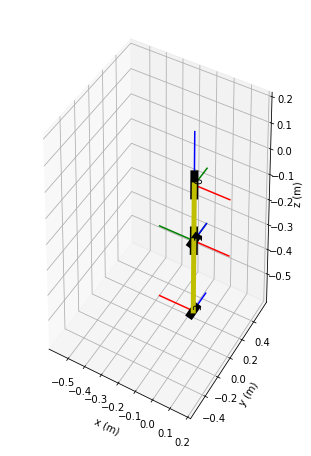

In [198]:
geom.draw_geom()

In [199]:
geom.T_0nc[1]

⎡                      l1x⋅cos(q₁)   l1y⋅sin(q₁)⎤
⎢cos(q₁)  -sin(q₁)  0  ─────────── - ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                      l1x⋅sin(q₁)   l1y⋅cos(q₁)⎥
⎢sin(q₁)  cos(q₁)   0  ─────────── + ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                            l1z                ⎥
⎢   0        0      1        ─── - 0.21537      ⎥
⎢                             m₁                ⎥
⎢                                               ⎥
⎣   0        0      0              1            ⎦

## Create dynamics

In [231]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions...
dq0_da0 = 0, tau_f = 0
dq0_da1 = 0, tau_f = 0
dq0_da2 = 0, tau_f = 0
dq1_da0 = 1, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da1 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da2 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq2_da0 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da1 = 1, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da2 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq3_da0 = 0, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
dq3_da1 = 0, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
dq3_da2 = 1, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 24
Creating H_b function...
Finished creating robot dynamics
CPU times: user 1min 18s, sys: 185 ms, total: 1min 18s
Wall time: 1min 17s


In [201]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 25
Creating H_b function...


In [232]:
sympy.Matrix(dyn.base_param)

⎡                  1.0⋅l3y                   ⎤
⎢                                            ⎥
⎢                  1.0⋅l3x                   ⎥
⎢                                            ⎥
⎢                  1.0⋅L3yz                  ⎥
⎢                                            ⎥
⎢                  1.0⋅l2y                   ⎥
⎢                                            ⎥
⎢                  1.0⋅L3xz                  ⎥
⎢                                            ⎥
⎢                  1.0⋅L3xy                  ⎥
⎢                                            ⎥
⎢                  1.0⋅L2xy                  ⎥
⎢                                            ⎥
⎢             1.0⋅l2x + 0.279⋅m₃             ⎥
⎢                                            ⎥
⎢            1.0⋅L3xx - 1.0⋅L3yy             ⎥
⎢                                            ⎥
⎢            1.0⋅L2xz - 0.279⋅l3z            ⎥
⎢                                            ⎥
⎢                  1.0⋅L3zz                  ⎥
⎢            

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [233]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

joint constraint number: 2
cartisian constraint number: 0
constraint number: 8
Condition number: 21.8604525462
x: [ 0.2345644  -0.21463422 -0.20302023 -0.99711727 -0.48931696 -0.498378
  0.67277535  0.05819404  0.31679806  0.88299783 -0.12027215  0.70466585
 -0.72116442 -0.21794184 -0.03391074  0.94187847 -0.88949978  0.1192841
  0.22695306 -0.32460437  0.4034641   0.8785773  -0.81205062 -0.58774257
  0.99962701  0.47334691  2.61309311 -0.71152133 -0.73061956  0.85936828
 -0.27682053  0.42745087  0.85968904  0.9580549   0.33686504  0.63829318
  0.58014684 -0.86353605  0.64812031]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   11.3674
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         21.8605             0

	Variables (c - c

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


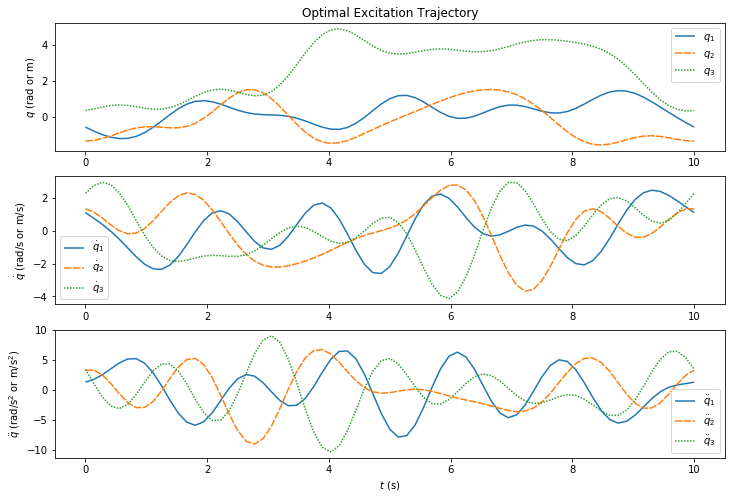

In [234]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [235]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [236]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [237]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [238]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [239]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


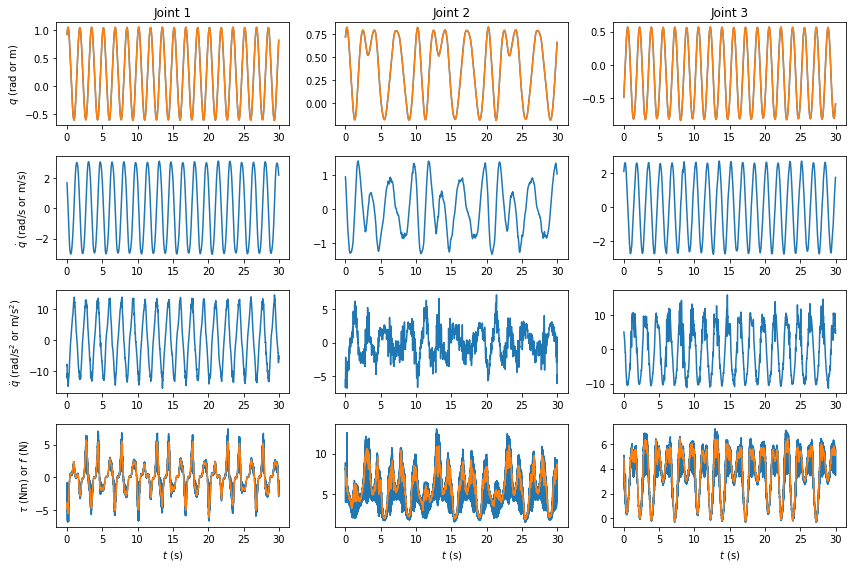

In [240]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [241]:
traj_optimizer.x_result

array([ 0.2345644 , -0.21463422, -0.20302023, -0.99711727, -0.48931696,
       -0.498378  ,  0.67277535,  0.05819404,  0.31679806,  0.88299783,
       -0.12027215,  0.70466585, -0.72116442, -0.21794184, -0.03391074,
        0.94187847, -0.88949978,  0.1192841 ,  0.22695306, -0.32460437,
        0.4034641 ,  0.8785773 , -0.81205062, -0.58774257,  0.99962701,
        0.47334691,  2.61309311, -0.71152133, -0.73061956,  0.85936828,
       -0.27682053,  0.42745087,  0.85968904,  0.9580549 ,  0.33686504,
        0.63829318,  0.58014684, -0.86353605,  0.64812031])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [242]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [243]:
print(W_b.shape, tau_s.shape)

((17970, 24), (17970,))


In [244]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [245]:
sympy.Matrix.hstack(sympy.Matrix(dyn.base_param), sympy.Matrix(xb_ols))

⎡                  1.0⋅l3y                       0.074445151266068  ⎤
⎢                                                                   ⎥
⎢                  1.0⋅l3x                       0.444294094117089  ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3yz                     0.00147247321324023 ⎥
⎢                                                                   ⎥
⎢                  1.0⋅l2y                      0.0309348191578367  ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3xz                    -0.000341120353469642⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3xy                     -0.0204855925496503 ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L2xy                     0.00164920211520721 ⎥
⎢                                                                   ⎥
⎢             1.0⋅l2

## Compare measured torque and predicted torque

### Generate predicted torque

In [246]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [247]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.002270301741251882
standard deviation of xb using OLS:
[2.31706662e-04 3.64499428e-04 1.85197569e-04 1.78212285e-03
 9.37242263e-05 7.64830648e-05 1.82110740e-04 8.03845900e-04
 1.80157996e-04 1.97527572e-04 1.35617274e-04 2.60397695e-04
 1.13801480e-04 1.68171811e-03 1.15913319e-03 7.37232175e-04
 4.86407231e-04 4.65990576e-04 3.13981530e-03 1.71759174e-02
 6.15787727e-04 1.40336021e-03 1.55554016e-03 1.35500993e-03]
percentage of standard deviation of xb using OLS: 
[0.00311245 0.0008204  0.12577313 0.05760896 0.27475413 0.00373351
 0.11042354 0.00095192 0.00169923 0.55591482 0.00103644 0.40630079
 0.00073408 0.0588114  0.07443275 0.28425867 0.00268109 0.00111539
 0.04651468 0.17232203 0.09667674 0.08618206 0.15323904 0.15458806]


### Plot measured torque and predicted torque

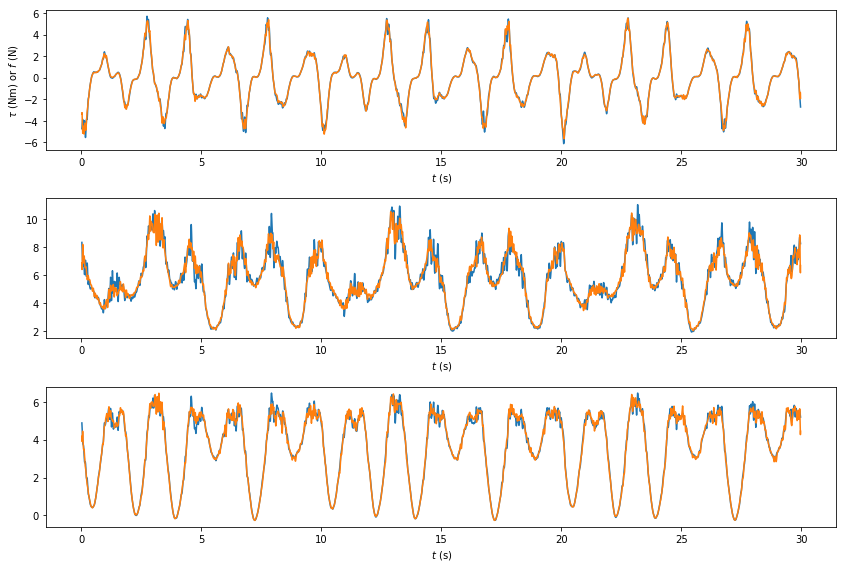

In [248]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [249]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [250]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [251]:
from identification import SDPOpt

bary_param_num = len(robot_def.bary_params)
H_func = dyn.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [252]:
len(robot_def.std_params)

In [253]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
                  (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05)]

In [256]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 40)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Ia3 param40
Solving problem...
WARN: A->p (column pointers) not strictly increasing, column 40 empty
[ 5.77992876e+00  9.25637561e-16  2.42499343e-25  4.63093879e+00
  5.21605282e-14 -3.28631424e-02 -3.30962310e-15  4.11799982e-08
  1.69858277e-09  1.00002520e+00  6.53177272e-03  1.15816752e-02
  5.94743960e-03  6.20436787e-02 -5.48318721e-02  1.24752354e-03
  3.95267656e-02  6.03171870e-03  1.18990765e-01 -4.02368249e-01
  3.43106907e-01 -6.63306625e-05  9.99992436e+00  9.04017362e-03
  6.93466766e-03 -6.29593411e-01 -2.10183002e-02 -3.41540901e-02
 -3.68474495e-03  1.40899523e-01 -3.11862073e-04  1.32296759e-01
  8.05502016e-02  1.81581396e-01 -1.99216885e-03  5.41461709e+00
  1.84032589e-02  1.13423340e-02  3.19126680e+00  0.00000000e+00]


## Compare measured torque and predicted torque

### Generate predicted torque

In [257]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

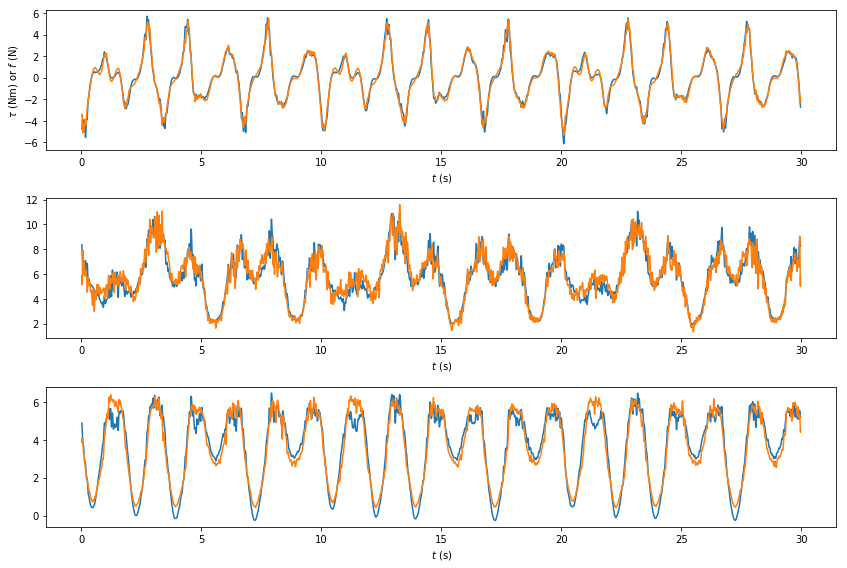

In [258]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [180]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.bary_params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx     5.1908247648314   ⎤
⎢                           ⎥
⎢L1xy  -1.0004589810178e-14 ⎥
⎢                           ⎥
⎢L1xz   -2.005283226391e-22 ⎥
⎢                           ⎥
⎢L1yy    4.17200887244173   ⎥
⎢                           ⎥
⎢L1yz  -3.07747623681386e-10⎥
⎢                           ⎥
⎢L1zz   -0.0308885287855175 ⎥
⎢                           ⎥
⎢l1x   -8.34913702993509e-21⎥
⎢                           ⎥
⎢l1y    1.49103980465019e-9 ⎥
⎢                           ⎥
⎢l1z     1.96715436340447   ⎥
⎢                           ⎥
⎢ m₁     9.83577191010522   ⎥
⎢                           ⎥
⎢Fc₁    0.00675301664959663 ⎥
⎢                           ⎥
⎢Fv₁    0.0122697517365324  ⎥
⎢                           ⎥
⎢Fo₁    0.00589522489669543 ⎥
⎢                           ⎥
⎢L2xx   0.0581823298048784  ⎥
⎢                           ⎥
⎢L2xy   -0.0573915249141683 ⎥
⎢                           ⎥
⎢L2xz   0.00138220278214081 ⎥
⎢                           ⎥
⎢L2yy   0.0444038650331139  ⎥
⎢         

In [181]:
from identification import barycentric2standard_params

In [48]:
sdp_opt_std.x_result

array([ 7.65896226e+00, -2.10120708e-14,  7.44053488e-22,  6.12272945e+00,
       -4.84816276e-16,  3.39179963e-05, -6.13332878e-18,  6.70553779e-09,
        1.29570196e-08,  3.37901136e+00,  3.33873168e-03,  6.47494505e-03,
        6.27971858e-03,  3.55053653e-02, -4.05293388e-03, -1.51967213e-02,
        1.39664671e-01,  2.90524196e-03,  1.13550313e-01,  2.91918949e-01,
       -3.93548962e-02,  1.49828497e-01,  2.99815679e+00,  2.11737976e-02,
        1.06816552e-02,  5.53079738e-01,  1.26416927e-02, -2.11461159e-02,
       -1.03171387e-03,  1.18406015e-01,  1.95451916e-03,  1.26378916e-01,
        4.34455753e-01,  8.36295752e-02, -6.17886172e-02,  2.03254367e+00,
        2.42997972e-02,  4.95561322e-03,  1.60361977e-01])

In [52]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def)

In [53]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.std_params), sympy.Matrix(x_std))

⎡I1xx    7.65896225700888   ⎤
⎢                           ⎥
⎢I1xy  -2.10120707876957e-14⎥
⎢                           ⎥
⎢I1xz  7.44029969013466e-22 ⎥
⎢                           ⎥
⎢I1yy    6.12272944962458   ⎥
⎢                           ⎥
⎢I1yz  -4.59103493585291e-16⎥
⎢                           ⎥
⎢I1zz   3.39179963245129e-5 ⎥
⎢                           ⎥
⎢r1x   -1.81512523565554e-18⎥
⎢                           ⎥
⎢r1y    1.98446737264628e-9 ⎥
⎢                           ⎥
⎢r1z    3.83455934896738e-9 ⎥
⎢                           ⎥
⎢ m₁     3.37901135638723   ⎥
⎢                           ⎥
⎢Fc₁    0.00333873167903131 ⎥
⎢                           ⎥
⎢Fv₁    0.00647494505331726 ⎥
⎢                           ⎥
⎢Fo₁    0.00627971857521939 ⎥
⎢                           ⎥
⎢I2xx   0.0275013188477063  ⎥
⎢                           ⎥
⎢I2xy  -0.00788476815221773 ⎥
⎢                           ⎥
⎢I2xz  -0.000608499145543505⎥
⎢                           ⎥
⎢I2yy    0.103754190446675  ⎥
⎢         